In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from matplotlib import cm
from tqdm import tqdm
import time
from tslearn import metrics
from tslearn.metrics import dtw, dtw_path
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.spatial.distance import cdist
from numba import njit, prange
import numba

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
import stumpy  # local load

In [3]:
np.random.seed(0)
n_ts, sz, d = 2, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
scaler0 = TimeSeriesScalerMeanVariance(mu=0, std=1)
scaler1 = TimeSeriesScalerMeanVariance(mu=0.5, std=1.8)
dataset_scaled0 = scaler0.fit_transform(dataset)
dataset_scaled1 = scaler1.fit_transform(dataset)
v_a = dataset_scaled0[0, :, 0]
v_b = dataset_scaled1[1, :, 0]

# Why LB before DTW?
Our goal to find best-motif of DTW in whole matrix.
But DTW calculation cost is high. On the other hand, LB has high correlation to DTW and lower calculation cost.

<img src="images_dtw/dtw lb corrleation.png" width="300">

# Cost comparison

### a.Calculation speed order
(Fast) [ LB_Kim > LB_Keogh > (ED) >> DTW ] (Slow)

### b.Distance advantage(tend to be small distance)
(Small) [ LB_Kim < LB_Keogh < DTW < (ED) ] (Great)

LB has advantage to calculate distance by skipping calculation area.  
We would calculated DTW, but its calculation cost is high.  
So We foucus on only meaningfull area by comapring LB and best ED(whold dataset).



### 1.LB Kim
Simplest LB calculation. But it won't work in z-normalized data due to the dependenc to max and min

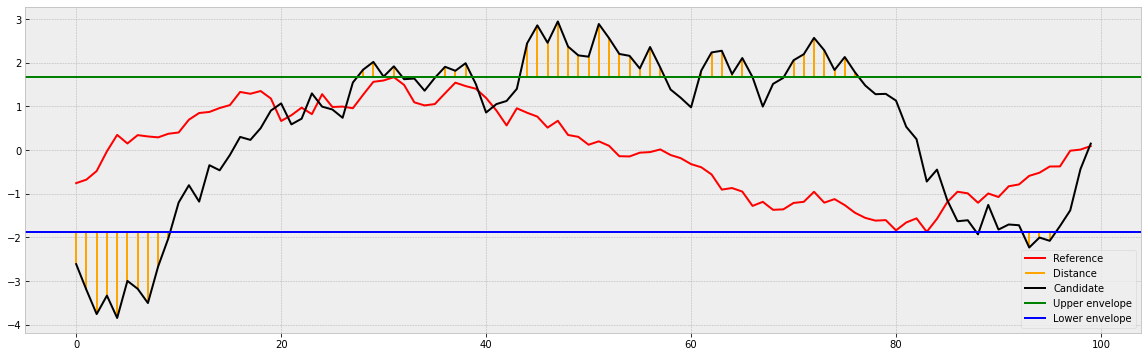

In [4]:
max_ = np.max(v_a)
min_ = np.min(v_a)

plt.plot(v_a, color="red", label="Reference")
plt.vlines(np.arange(sz), v_b, 
    np.clip(v_b, min_, max_), color='orange', label="Distance")
plt.plot(v_b, color="k", label="Candidate")
plt.axhline(max_, color="green", label="Upper envelope")
plt.axhline(min_, color="blue", label="Lower envelope")
plt.legend()
plt.show()

In [5]:
def lb_kim(ts, q_min, q_max):
    return np.sqrt(np.linalg.norm(ts[ts<q_min]) + np.linalg.norm(ts[ts>q_max]))

d_lb_kim = lb_kim(dataset_scaled1[1, :, 0], min_, max_)
d_lb_kim

4.846380814250661

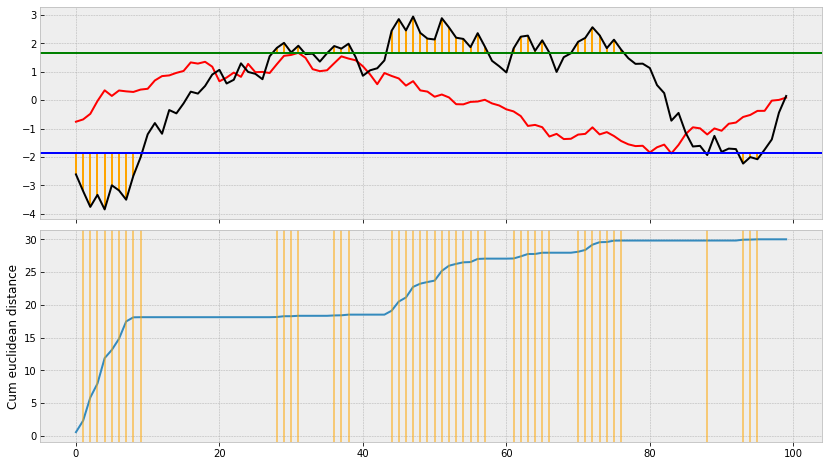

In [6]:
cum_lb_kim = []
score = 0
for i in range(len(v_b)):
    x = v_b[i]
    if x < min_:
        score += np.square(x - min_)
    elif x > max_:
        score += np.square(x - max_)

    cum_lb_kim.append(score)

diff_cum = np.diff(cum_lb_kim)
idx_change = np.where(diff_cum != 0)[0] + 1

fig, axs = plt.subplots(2, 1, sharex=True, 
                        gridspec_kw={'hspace': 0.05}, figsize=(14, 8))

axs[0].plot(v_a, color="red")
axs[0].vlines(np.arange(sz), v_b, 
    np.clip(v_b, min_, max_), color='orange')
axs[0].plot(v_b, color="k")
axs[0].axhline(max_, color="green")
axs[0].axhline(min_, color="blue")

axs[1].plot(cum_lb_kim)
for i in idx_change:
    axs[1].axvline(i, color='orange', alpha=0.5)
axs[1].set_ylabel("Cum euclidean distance")


plt.show()

### 2.LB Keogh

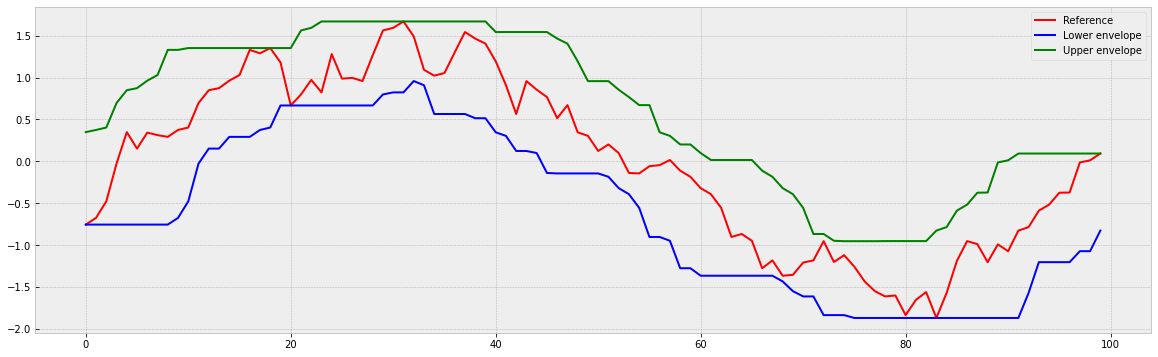

In [7]:
envelope_down, envelope_up = metrics.lb_envelope(v_a, radius=8)
plt.plot(v_a, "r-", label='Reference')
plt.plot(envelope_down[:, 0], "b-", label='Lower envelope')
plt.plot(envelope_up[:, 0], "g-", label='Upper envelope')
plt.legend()
plt.show()

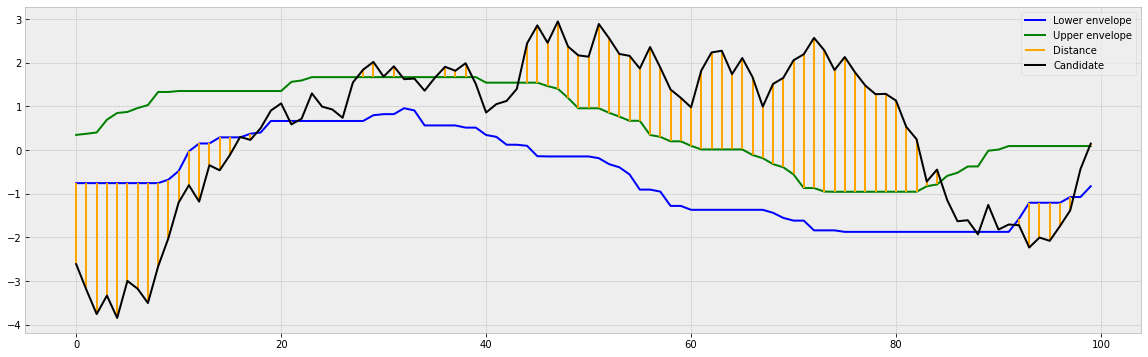

In [8]:
plt.plot(envelope_down[:, 0], "b-", label='Lower envelope')
plt.plot(envelope_up[:, 0], "g-", label='Upper envelope')
plt.vlines(np.arange(sz), v_b, 
    np.clip(v_b, envelope_down[:, 0], envelope_up[:, 0]), color='orange', label="Distance")
plt.plot(v_b, color="k", label="Candidate")
plt.legend()
plt.show()

In [9]:
d_lb_keogh = metrics.lb_keogh(v_b, v_a, radius=8)
d_lb_keogh

14.756247148729072

### 3.DTW

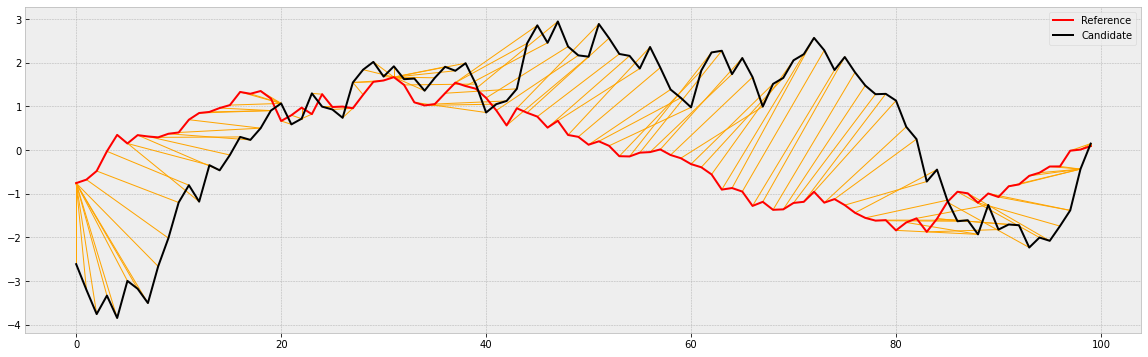

In [10]:
path, sim = metrics.dtw_path(v_a, v_b, global_constraint="sakoe_chiba", sakoe_chiba_radius=8) # default setting(intendedly specified)
gap_plot = np.max(v_b)*1.2
x_path = np.asarray(path)
y_path = np.stack([v_a[x_path[:, 0]], v_b[x_path[:, 1]]]).T
for i in range(x_path.shape[0]):
    plt. plot(x_path[i, :], y_path[i, :], linewidth=1, color='orange')
plt.plot(v_a, "r-", label='Reference')
plt.plot(v_b, "k", label="Candidate")
plt.legend()
plt.show()

In [11]:
d_dtw = dtw(v_a, v_b, global_constraint="sakoe_chiba", sakoe_chiba_radius=8)
d_dtw

15.408369820113755

### 4.ED

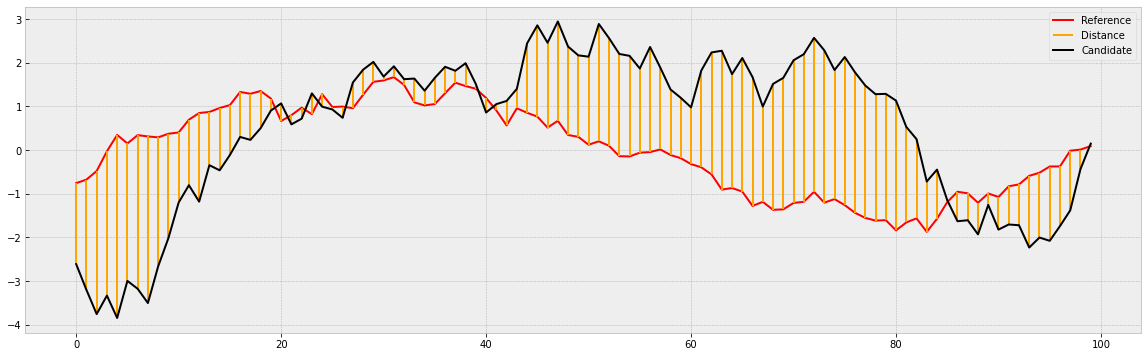

In [12]:
plt.plot(v_a, color="r", label='Reference')
plt.vlines(np.arange(sz), v_b, v_a, color='orange', label="Distance")
plt.plot(v_b, color="k", label="Candidate")
plt.legend()
plt.show()

In [13]:
d_ed = np.linalg.norm(v_b-v_a)
d_ed

19.96879907914127

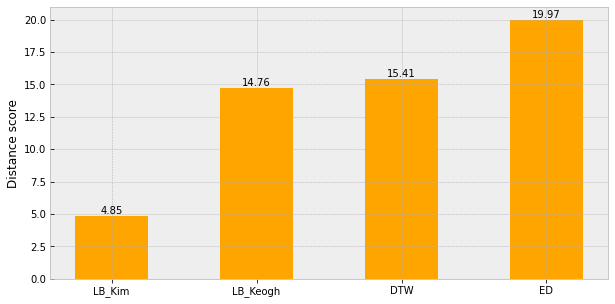

In [14]:
name = ["LB_Kim", "LB_Keogh", "DTW", "ED"]
D = [d_lb_kim, d_lb_keogh, d_dtw, d_ed]

plt.figure(figsize=(10, 5))
hbars = plt.bar(name, D, label=name, color="orange", width=0.5)
plt.bar_label(hbars, fmt='%.2f')
plt.ylabel("Distance score")
plt.show()

# LB MP calculation
On current Numba, First-class function type feature is experimental.  
Only difference of LB(Kim) MP and LB(Keogh) is envelop function.  
**LBMP and DTWMP have to support indices.** 

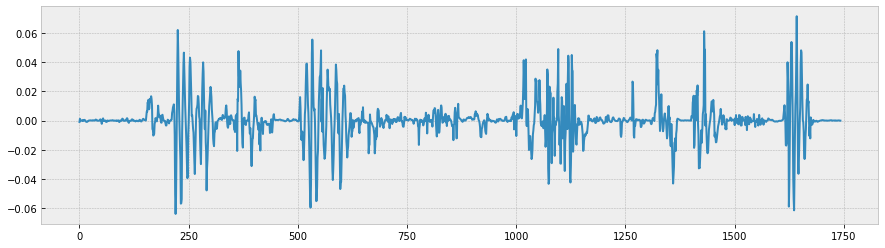

In [2]:
dfx = pd.read_csv("a1_va3.pkl")
v = dfx.values[:, 1]
plt.figure(figsize=(15, 4))
plt.plot(v)
plt.show()

## 1.LB(Kim) MP
This LB cut majority of calculation area in espicially z-normalized series.
It won't work properly this time. I'll skip this for now.

## 2.LB(Keogh) MP

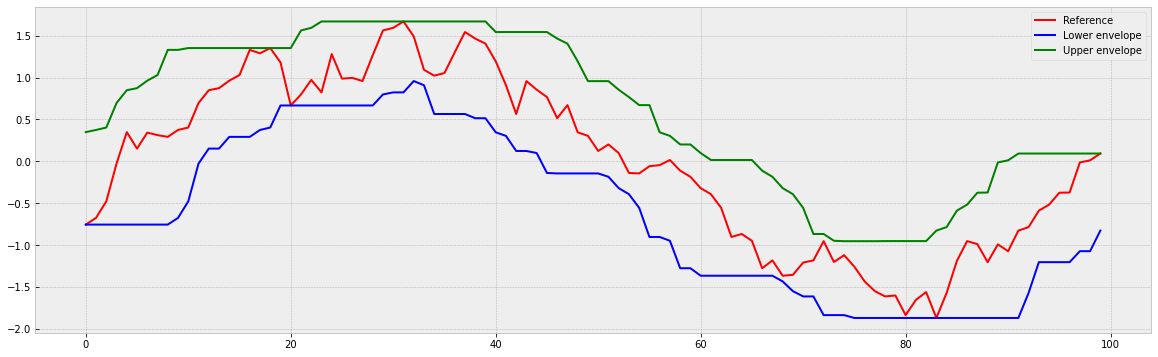

In [16]:
@njit(
    # "(f8[:], f8[:], f8[:])"
    fastmath=True,
)
def lb_dist(L, U, t):
    idx_up = t > U
    idx_down = t < L
    dist_up = np.linalg.norm(t[idx_up]-U[idx_up])
    dist_down = np.linalg.norm(L[idx_down]-t[idx_down])
    return dist_up**2 + dist_down**2

@njit(
    # "(f8[:], i8)"
    parallel=True,
    fastmath=True,
)
def lb_envelope_keogh(ts, radius):
    n_t = ts.shape[0]
    env_up = np.empty(n_t)
    env_down = np.empty(n_t)

    for i in prange(n_t):
        min_idx = i - radius
        max_idx = i + radius + 1
        if min_idx < 0: min_idx = 0
        if max_idx > n_t: max_idx = n_t

        env_down[i] = np.min(ts[min_idx:max_idx])
        env_up[i] = np.max(ts[min_idx:max_idx])

    return env_down, env_up

envelope_down, envelope_up = lb_envelope_keogh(v_a, radius=8)
plt.plot(v_a, "r-", label='Reference')
plt.plot(envelope_down, "b-", label='Lower envelope')
plt.plot(envelope_up, "g-", label='Upper envelope')
plt.legend()
plt.show()

In [30]:
T_A = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius
T_B = None
ignore_trivial=True

if T_B is None:
    T_B = T_A
    ignore_trivial = True

(T_A, μ_Q, σ_Q) = stumpy.core.preprocess(T_A, m)

(T_B, M_T, Σ_T) = stumpy.core.preprocess(T_B, m)

n_A = T_A.shape[0]
n_B = T_B.shape[0]
l = n_A - m + 1

n_threads = numba.config.NUMBA_NUM_THREADS

excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))
indices_pruned = np.arange(500, 600)

if indices_pruned is None:
    indices_pruned = np.array([]).astype(np.int64)
else:
    indices_pruned = indices_pruned.astype(np.int64)

if ignore_trivial:
    a_start = np.arange(l)
    b_start = np.arange(l)
    ndist_counts = np.full(l, l)
    if len(indices_pruned) > 0:
        mask_pruned = np.full(l, True)
        mask_pruned[indices_pruned] = False
        a_start = a_start[mask_pruned]
        b_start = a_start
        ndist_counts = ndist_counts[mask_pruned]
else:
    lb = n_B - m + 1
    a_start = np.arange(l)
    b_start = np.arange(l)
    ndist_counts = np.full(lb, l)
    if len(indices_pruned) > 0:
        mask_pruned = np.full(l, True)
        mask_pruned[indices_pruned] = False
        a_start = a_start[mask_pruned]
        ndist_counts = ndist_counts[mask_pruned]

a_ranges = stumpy.core._get_array_ranges(ndist_counts, n_threads, False)

array([1584, 1584, 1584, ..., 1584, 1584, 1584])

In [40]:
ρ = np.full((n_threads, l), np.Inf, dtype=np.float64)
I = np.full((n_threads, l), -1, dtype=np.int64)
    
uint64_m = np.uint64(m)
for thread_idx in prange(n_threads):
    for i_a in range(a_ranges[thread_idx, 0], a_ranges[thread_idx, 1]):
        uint64_ia = np.uint64(a_start[i_a])
        a = (T_A[uint64_ia:uint64_ia+uint64_m] - μ_Q[uint64_ia])/σ_Q[uint64_ia]
        L, U = lb_envelope_keogh(a, r)

        for i_b in b_start:
            if ignore_trivial == True:
                uint64_ib = np.uint64(i_b)
                if np.abs(i_b - uint64_ia) > excl_zone:
                    b = (T_B[uint64_ib:uint64_ib+uint64_m] - M_T[uint64_ib])/Σ_T[uint64_ib]
                    dist = lb_dist(L, U, b)
                    if dist < ρ[thread_idx, uint64_ia]:
                        ρ[thread_idx, uint64_ia] = dist
                        I[thread_idx, uint64_ia] = uint64_ib

            else:
                uint64_ib = np.uint64(i_b)
                b = (T_B[uint64_ib:uint64_ib+uint64_m] - M_T[uint64_ib])/Σ_T[uint64_ib]
                dist = lb_dist(L, U, b)
                if dist < ρ[thread_idx, uint64_ia]:
                    ρ[thread_idx, uint64_ia] = dist
                    I[thread_idx, uint64_ia] = uint64_ib

for thread_idx in range(1, n_threads):
    mask = (ρ[thread_idx, :] < ρ[0, :]) & (I[thread_idx, :] != I[0, :])
    ρ[0, :][mask] = ρ[thread_idx, :][mask]
    I[0, :][mask] = I[thread_idx, :][mask]
    
P = np.sqrt(ρ[0, :]) #  I[0, :]

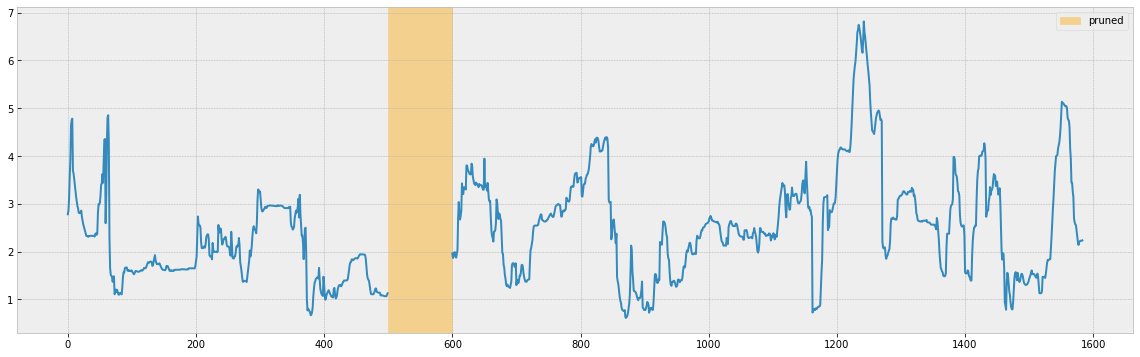

In [41]:
plt.plot(P)
plt.axvspan(500, 600, alpha=0.4, color="orange", label="pruned")
plt.legend()

In [3]:
T_A = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius
indices_pruned = np.arange(500, 600)
T_B = None

mp_ = stumpy.lbKeogh_MP(T_A, m, r, indices_pruned=indices_pruned)

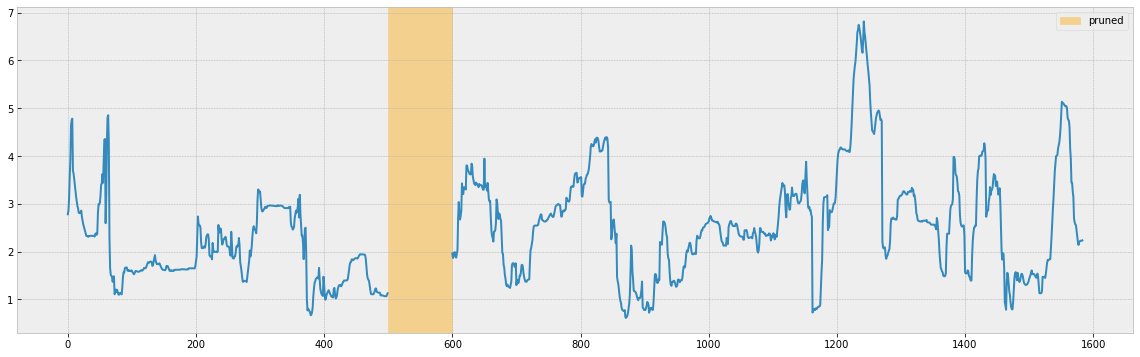

In [5]:
plt.plot(mp_[0])
plt.axvspan(500, 600, alpha=0.4, color="orange", label="pruned")
plt.legend()

### without indices pruned

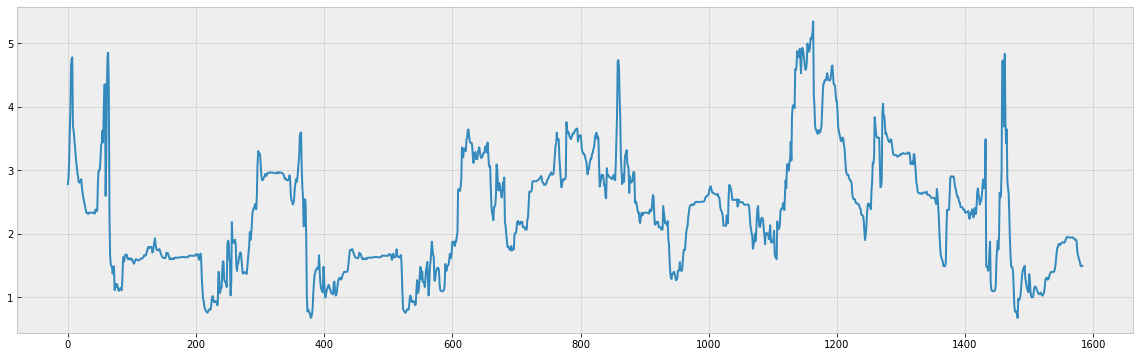

In [43]:
v = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius
# out_LB_Keogh = lbKeogh_MP(v, m, r, indices_pruned=np.arange(500, 600))
out_LB_Keogh = stumpy.lbKeogh_MP(v, m, r)

plt.plot(out_LB_Keogh[0])

### with indices pruned

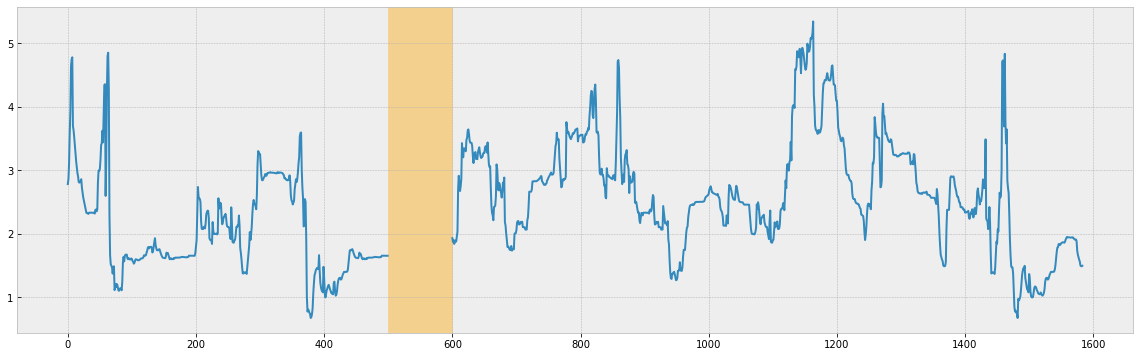

In [44]:
out_LB_Keogh = stumpy.lbKeogh_MP(v, m, r, indices_pruned=np.arange(500, 600))
plt.plot(out_LB_Keogh[0])
plt.axvspan(500, 600, color="orange", alpha=0.4)